# Sentiment Analysis 2020 Election Tweets

## **Research Question:** *Quantifying public engagement toward political parties on twitter to predict election results*

#### Introduction 
##### Social media platforms like Facebook and Twitter have entirely altered how we share news and opinions regarding current affairs. Twitter is an integral part of the mainstream media and has allowed it to become a platform for electoral campaigning. Influential individuals and organizations including politicians and political parties have increased the use of Twitter to change public sentiment regarding current affairs. During the 2020 US presidential election campaign, millions of tweets were posted by users around the world. Fortunately, we have access to detailed information regarding these tweets. 
##### The data used in this particular research consist of the two primary election candidates, Donald Trump, and Joe Biden. We have separate data sets of tweets that contain their names. The tweet data was accessed from Kaggle which has been collected since October 2020 for approximately one month till the election month of November 2020. There are many tools to measure the popularity of someone on platforms like Twitter. For instance, the number of tweets for each candidate could demonstrate their number of supporters. Similarly, the public engagement on these tweets like the number of retweets would indicate how well-known a particular tweet is. Similarly, the number of likes on a particular tweet is a prime variable to measure the popularity of a tweet and whether people support a particular message or not. Moreover, the location origin of a tweet is of utmost importance since that would indicate whether the tweet count of a specific state within the US eventually dictates a relation between the real vote counts of the mentioned state and its ultimate result.
##### Unfortunately, the nature of tweets is ambiguous since it represents emotions and so, we must identify and categorize them. To analyze whether these opinions are in support or against the candidates, in this case, Biden or Trump, a sentiment analysis would be the right approach. The goal of sentiment analysis is to understand the opinions of people. It analyzes emotions, opinions, and attitudes towards issues and uses natural language processing and machine learning techniques to automatically identify subjective information from text data and then categorize it into positive, negative, or neutral sentiments. 
##### After working with the data, I observed how the likes, retweet counts, and user follower counts of tweets were positively related to the vote counts of most states in the United States. It is very important to realize that I hypothesized that tweets with positive sentiments or emotions would have a positive correlation with vote counts in general. My plots and figures indeed affirmed my hypothesis since the plots had a direct relation to my variables.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import re # importing regex to filter tweets
import nltk # improting natural language tool kit which contains the sentiment analyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
# analyzer in the pre-built vader model to detect text polarity

## Data Loading and Wrangling

##### Reading the csv files for both the election candidates, Donald Trump and Joe Biden

In [2]:
dft = pd.read_csv(r'C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\hashtag_donaldtrump.csv', lineterminator = '\n')

In [3]:
dfb = pd.read_csv(r'C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\hashtag_joebiden.csv', lineterminator = '\n')

##### Concatenating both the Donald Trump and Joe Biden Data Sets 

In [4]:
# We add a new column of the candidate name to both the data sets to keep them distinct
dft["Candidate Name"] = "Donald Trump"
dfb["Candidate Name"] = "Joe Biden"
trump_biden_data = pd.concat([dft, dfb]) # We now merge or concatenate both the data sets


##### Dropping the rows which are unrelated to the research question

In [5]:
# Removing the unneccesaary columns which will not be needed
trump_biden_data = trump_biden_data.drop(columns = ['tweet_id', 'source', 'user_id', 'user_screen_name', 'user_description', 'user_join_date', 'lat', 'long', 'state_code', 'collected_at', 'continent', 'city', 'user_location'])

##### We check the countries where the tweets have been collected

<AxesSubplot: xlabel='country'>

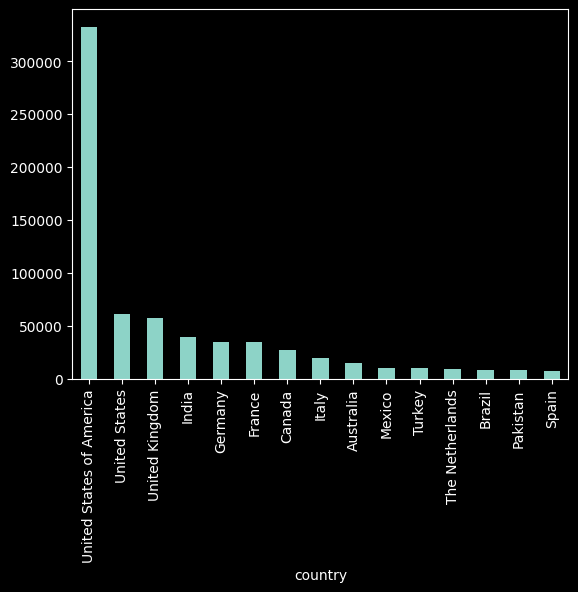

In [6]:
trump_biden_data.groupby('country')['tweet'].count().sort_values(ascending=False).head(15).plot.bar()

##### We observe that there are tweets from other countries apart from the US so we further clean the country column and only keep the tweets which are from the US. Moreover, observe that the first two bars both represents tweets from the USA so, we must keep both of them as done below

In [7]:
trump_biden_data = trump_biden_data.loc[(trump_biden_data['country'] == "United States") | (trump_biden_data['country'] == "United States of America")] 
trump_biden_data.isna().sum()

created_at                  0
tweet                       0
likes                       0
retweet_count               0
user_name                   1
user_followers_count        0
country                     0
state                   61933
Candidate Name              0
dtype: int64

##### After all the data wrangling we finally check whether there are any columns that contains the NaN values so we could remove them as well since, state anme is an integral part of the research question.

In [8]:
trump_biden_data = trump_biden_data.dropna(subset = 'state') # we remove the tweets with na values in the state column

##### Since there can be tweets which can be present in both Biden and Trump data sets as there could be numerous tweets that may contains both their names. We have to account for the repeated tweets after both the sets were concatenated.

In [9]:
trump_biden_data = trump_biden_data.drop_duplicates(subset = 'tweet', keep = False)

##### Lastly, we must remove all the tweets that were tweeted after the election poll that was held on November 3rd 2020. We would only account tweets that were tweeted before the election to accurately predict election results themselves 

In [10]:
trump_biden_data = trump_biden_data.loc[(trump_biden_data['created_at'] < '2020-11-03 24:00:00')] # only keeps the observations until the day of election which was November 3rd 2020

##### To further progress in the project, identifying sentiment state for each tweet was crucial. For that purpose, the tweet data had to be heavily cleaned because the sentiment analyzer which we will be working with only allows plain text data. Unfortunately, our tweet messages were far from clean and contained a lot of data which was not acceptable to the analyzer. For this purpose regex (regular expressions) was imported to clean each tweet in the combined data set.

##### The following code cleans the tweet messages very carefully and leaves us with a clean and plain textual sentence. We define a function that takes in a string of characters. It then turns every letter into lower case. It removes all the apostrophes from the string, removes # hashtags in the beginning, middle or at the end of a tweet. Similarly, it removes the @ mentions in a similar way that maybe used inside a tweet. The function then removes any sort of punctuations including commas, question mark and exclamation mark. Furthermore, it removes any mentioned links and websites that starts with 'https'. It then splits all the words into a list to check for stop words from a pre-specified list and remove them respectively from the list. Stop words are words in a sentence that are of no importance and which does not bring any new meaning to the message. Once stop words are removed from the list of words, they are then joined back again as a sentence ready for further analysis.

In [11]:
stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from",
"put", "rather", "said", "same", "ask", "about"] # randomly made a list of some words considered to be unuseful
def clean_tweet(tweet):
    clean = tweet.lower() # lowercasing all the letters in the tweet
    clean = re.sub("'", "", clean) # removing ' from tweets
    clean = re.sub("#[A-Za-z0-9_]+","", clean) # removing hashtags 
    clean = re.sub("@[A-Za-z0-9_]+","", clean) # removing mentions
    clean = re.sub('[()!?]', ' ', clean) # removing punctuations including commas, 
                                       # exclamation marks question marks etc
    clean = re.sub('\[.*?\]',' ', clean) 
    clean = re.sub(r'http\S+', '', clean) # removing any website links
    clean = re.sub("[^a-z0-9]"," ", clean) # removes all non-alphabetic 
                                         #letters and keeps alphabetic and numbers 
    clean = clean.split() # splits the tweet string into a list
    clean = [word for word in clean if not word in stopwords] # comprehension to remove any stopwords from the list
    clean = " ".join(word for word in clean) # joins back all the words from the list as a sentece
    return clean
  

##### We now create a new column in our data set for the cleaned tweet and apply our defined function on every tweet in our data set. 

In [12]:
trump_biden_data['clean'] = trump_biden_data['tweet'].apply(lambda x: clean_tweet(x))  

##### In this project, the use of a lexicon based sentimental analysis is done through VADER (Valence Aware Dictionary and Sentiment Reasoner) which automatically identifies the sentiment of a text based on words and slangs. The function SentimentIntensityAnalyzer is present in the natural language toolkit (NLTK) of python that takes in our cleaned data.

##### We now apply the pre-defined sentiment intensity analyzer function on our cleaned tweets. Created a new column for the polairty score for each tweet. This simply calculates the polarity scores of each tweet between negative, neutral and positive. We then observe the compund score, the addition of all scores of the three categories. If the compound is closer to +1 then the text is positive and if it is closer to -1 then it would be considered negative. 

In [13]:
sent_analyzer = SentimentIntensityAnalyzer() # assigning the analyzer to a variable
trump_biden_data['polarity_score'] = trump_biden_data['clean'].apply(lambda x: sent_analyzer.polarity_scores(x))
# creating the sentiment column and using the analyzer on the cleaned tweets to calculate polarity scores

##### The compound score is being categorized between positive, neutral or negative. As mentioned before, a positive compound score will be considered a positive tweet and any compound score that is negative will be considered negative tweet. 

In [14]:
def emotion_state(sentiment_score):
  """
  This function takes in the sentiment score values and identifies what emotion does the score refers to
  between the 3 general states of Positive, Negative and Neutral 
  """
  if sentiment_score['compound'] >= 0.05: # creating a threshold of positive tweets for the polarity scores 
    return "Positive"
  elif sentiment_score['compound'] <= -0.05: # creating a threshold of negative tweets for the polarity scores
    return "Negative"
  else:
    return "Neutral" 


##### This is the most important part of our code to continue our analysis. We pick all the tweets that has a positive sentiment. As mentioned in the introduction we assumed that the all engagement on positive tweets should have a positive relationship with the vote counts of a particular state. 
##### Note that this dataset still contains both the candidates tweets.

In [15]:
trump_biden_data['Sentiment'] = trump_biden_data['polarity_score'].apply(lambda x: emotion_state(x)) # applying the function and categorozing each tweet in the data set

In [16]:
only_positive = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Positive']

##### The following code reads the data from teh Election Results Data set. This is the preseident county dat set with the candidate names along with it. After reading the csv file, I only keep the observations with Joe Biden and Donald Trump and remove all other candidates. I then categorized the data set with state and candidate and also changed the column name so merging could become easier.

In [17]:
results = pd.read_csv(r"C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\president_county_candidate.csv")
results = results.loc[(results['candidate'] == "Joe Biden") | (results['candidate'] == 'Donald Trump')]
tvbs = results.groupby(['state', 'candidate']).sum('total_votes')
tvbs = tvbs.reset_index()
tvbs.rename(columns = {'candidate':'Candidate Name'}, inplace = True)
tvbs.reset_index()


,index,state,Candidate Name,total_votes,won
0,0,Alabama,Donald Trump,1441168,54
1,1,Alabama,Joe Biden,849648,13
2,2,Alaska,Donald Trump,189892,20
3,3,Alaska,Joe Biden,153405,17
4,4,Arizona,Donald Trump,1661686,10
...,...,...,...,...,...
97,97,West Virginia,Joe Biden,235984,0
98,98,Wisconsin,Donald Trump,1610065,58
99,99,Wisconsin,Joe Biden,1630673,14
100,100,Wyoming,Donald Trump,193559,21


In [42]:
merge_pos_vote = pd.merge(only_positive, tvbs, on = ['state', 'Candidate Name'])
mean_pos_table = merge_pos_vote.groupby('state').mean()

C:\Users\danis\AppData\Local\Temp\ipykernel_19348\4161400837.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_pos_table = merge_pos_vote.groupby('state').mean()


,likes,retweet_count,user_followers_count,total_votes,won
state,,,,,
Alabama,6.213256,1.645533,9146.608069,1.115576e+06,31.432277
Alaska,0.845771,0.159204,1621.815920,1.706501e+05,18.417910
Arizona,3.372333,0.855040,2447.370861,1.666857e+06,7.527594
Arkansas,1.295455,0.357955,1661.198864,6.229000e+05,42.863636
California,6.952301,1.637011,7879.420584,8.208602e+06,28.178822


## Summary Statistics Tables

##### The following summary statistics table shows detailed information regarding retweets of the tweets that mentions both the election candidates, Joe Biden adn Donald Trump. Firstly, note that the number of observations for Biden is much lower than Trump's. Yet, we see that the mean retweet for Joe Biden is higher than Donald Trump. This is because there are more retweets of the tweets with Biden mentioned than Trump. Moreover, the maximum number of retweets on a single tweet relating to Joe Biden is 3 times larger than of the maximum from the tweets which mentions Trump. This significance further shows to be true since the standard deviation of the retweets of Biden is double of that of Trump's meaning that the retweets are more spread out and much far from the mean when compared to Trump's retweet data. This hsows high variability of retweet counts in tweets relating to Biden. It is evident through the retweets that Biden's message and campaign is more cirulating and is much stornger.

In [19]:
trump_biden_data.groupby('Candidate Name')["retweet_count"].sum()

Candidate Name
Donald Trump    212743.0
Joe Biden       267456.0
Name: retweet_count, dtype: float64

In [20]:
trump_biden_data.groupby('Candidate Name')["retweet_count"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104469.0,2.036422,42.490713,0.0,0.0,0.0,0.0,5986.0
Joe Biden,76855.0,3.480008,85.217549,0.0,0.0,0.0,0.0,17652.0


##### We categorize all the positive tweets between candidate names and now see the number of retweet counts once again. We observe how the number of retweet counts has decreased after extracting only positive tweets. Nevertheless the average number of likes for Joe Biden has increased from 3.48 to 4 when compared to mixed sentiment from earlier. Biden's standard deviation remains high in the only positive tweets as well. Infact it is three times more high than Trump's deviation. Biden's positive tweets are much more impactful in general when compared to Trump's.

In [21]:
only_positive.groupby('Candidate Name')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34864.0,2.296925,39.664534,0.0,0.0,0.0,0.0,3243.0
Joe Biden,27183.0,4.032557,119.677824,0.0,0.0,0.0,0.0,17652.0


##### The table below shows the aforementioned information where there is a higher number of tweets of Donald Trump than Joe Biden. Moreover, the total number of likes with Joe Biden tweets is higher than Trump's total likes. This leads to the obvious conclusion that the average number of likes received by Biden tweets is higher than Trump's tweeets as shown in the table. It is quite spectacular to observe that the maximum number of likes on a single tweet of Biden is almost seven times more than any tweet that mentions Trump. This clearly indicates Biden's populairty in general.

In [22]:
trump_biden_data.groupby('Candidate Name')["likes"].sum()

Candidate Name
Donald Trump     777854.0
Joe Biden       1035628.0
Name: likes, dtype: float64

In [23]:
trump_biden_data.groupby('Candidate Name')["likes"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104469.0,7.445788,173.382859,0.0,0.0,0.0,1.0,25987.0
Joe Biden,76855.0,13.475089,694.554198,0.0,0.0,0.0,1.0,165702.0


##### We categorize all the positive tweets between candidate names and now see the number of likes once again. We observe how the number of tweets has decreased after extracting only positive tweets. Nevertheless the average number of likes for Joe Biden has increased from 13 to 17 when compared to mixed sentiment. Biden's standard deviation still remains high in the only positive tweets as well. We can also see that the highest number of likes on a Biden tweet is ten times more than of any positive tweet related to trump. This may indicate that Biden's message is more powerful or patriotic on the social media platform.

In [24]:
only_positive.groupby('Candidate Name')['likes'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34864.0,8.760756,170.823100,0.0,0.0,0.0,1.0,16154.0
Joe Biden,27183.0,17.656072,1046.150264,0.0,0.0,0.0,2.0,165702.0


##### Note that the total user follower count and number of tweets both for Biden are lower than Trump. Still, people who tweeted about Biden have a higher average following on Twitter than the users who tweeted about Trump. Although user with Trump tweets has a higher number of total followers, there is one speicific user who has the highest follower count that tweeted about Biden that was higher than any person who tweeted about Trump with about 5.7 million followers (FYI: It is Perez Hamilton). It is worth mentioning the interquartile ranges for user followers variable for each candidate. The inter-quartile range (IQR) for trump user follower is 2548 while Biden's IQR is 2869. Biden's higher IQR indicates the higher dispersion of followers count which can also be observed by a higher standard deviation of followers of Biden supporters.

In [25]:
trump_biden_data.groupby('Candidate Name')["user_followers_count"].sum()

Candidate Name
Donald Trump    884502213.0
Joe Biden       761482933.0
Name: user_followers_count, dtype: float64

In [26]:
trump_biden_data.groupby('Candidate Name')["user_followers_count"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104469.0,8466.647647,81150.650294,0.0,138.0,701.0,2686.0,4163175.0
Joe Biden,76855.0,9908.046750,87234.912210,0.0,144.0,792.0,3013.0,5750841.0


##### Note that the total user follower count and number of tweets both for Biden are lower than the original one with all sentiments and still lower than trump. Nevertheless, people who tweeted about Biden still have a higher mean following on Twitter when compared to Trump. Moreover, Biden's standard deviation remains higher than trump in the number of followers who supports Biden.

In [27]:
only_positive.groupby('Candidate Name')['user_followers_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34864.0,7474.595514,63886.659867,0.0,136.0,687.0,2594.0,4163175.0
Joe Biden,27183.0,9484.708237,88812.059315,0.0,146.0,786.0,2912.0,5750841.0


## Plots and Figures

##### The following code extracts out the tweets with the highest number of likes by state name for each candidate. We then compare both the candidates likes wise based on the state with a bar plot.

In [28]:
top20_likes = only_positive.groupby('state')['likes'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_likes = only_positive.groupby(['state', 'Candidate Name'])['likes'].mean().reset_index()
pos_table_likes = pos_table_likes[pos_table_likes['state'].isin(top20_likes)]

##### The code outputs the highest mean number of likes for all positive tweets of the top 20 states by Candidates. We observe that NewYork has the highest number of likes on average for Joe Biden positive tweets. It is not a coincidence as we will see that Joe Biden infact did win in NewYork and the District of Columbia while Trump won in Indiana where he had a higher number of likes on positive tweets 

[Text(0.5, 1.0, 'Highest Mean Number of Likes of All Positive Tweets of 20 States by Candidate'),
 Text(0.5, 0, 'Average likes'),
 Text(0, 0.5, 'State')]

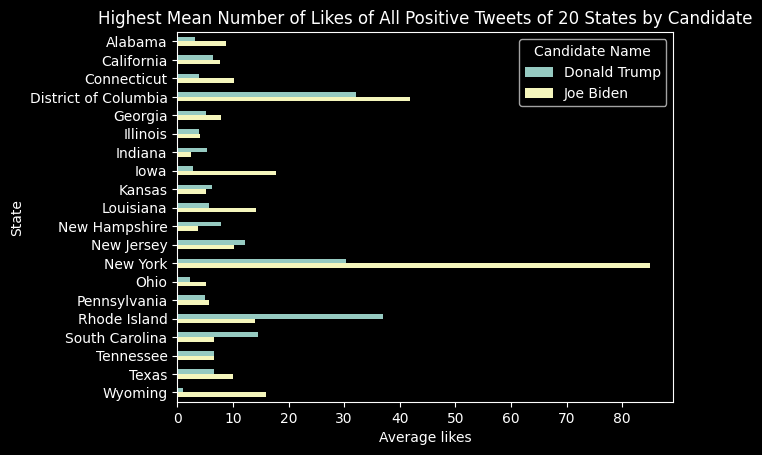

In [29]:
sns.barplot(data = pos_table_likes,x = 'likes', y = 'state', hue = 'Candidate Name', width = 0.5).set(title = 'Highest Mean Number of Likes of All Positive Tweets of 20 States by Candidate', xlabel = 'Average likes', ylabel = 'State')

##### The following code extracts out the tweets with the highest number of retweet count by state name for each candidate. We then compare both the candidates retweet counts wise based on the state with a bar plot.

In [30]:
top20_retweets = only_positive.groupby('state')['retweet_count'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_retweets = only_positive.groupby(['state', 'Candidate Name'])['retweet_count'].mean().reset_index()
pos_table_retweets = pos_table_retweets[pos_table_retweets['state'].isin(top20_retweets)]

##### The code outputs the highest average number of retweets for all positive tweets of the top 20 states by Candidates. We observe that NewYork and District of Columbia has the highest number of average retweet counts for Joe Biden's positive tweets. It is not a coincidence as we will see that Joe Biden infact did win in NewYork and the District of Columbia. Similarly, Trump won in South carolina where he had a higher average number of retweet counts on his positive tweets 

[Text(0.5, 1.0, 'Highest Average Retweet Count of All Positive Tweets of the top 20 States by Candidate'),
 Text(0.5, 0, 'Average Retweet Count'),
 Text(0, 0.5, 'State')]

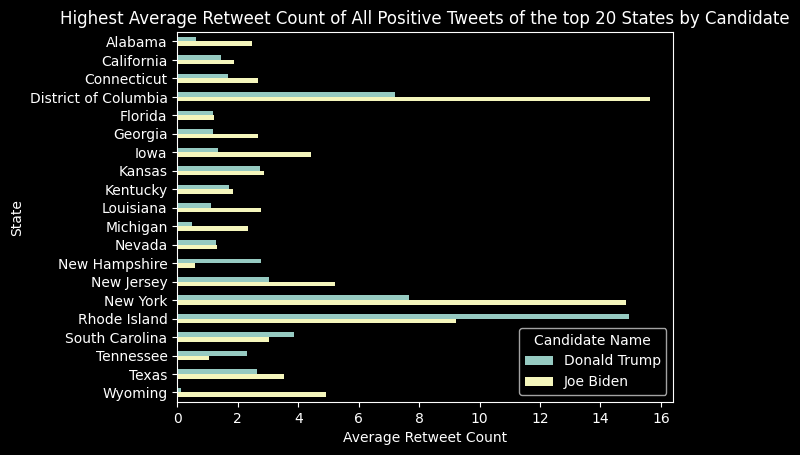

In [31]:
sns.barplot(data = pos_table_retweets,x = 'retweet_count', y = 'state', hue = 'Candidate Name', width = 0.5).set(title = 'Highest Average Retweet Count of All Positive Tweets of the top 20 States by Candidate', xlabel = 'Average Retweet Count', ylabel = 'State')

##### The following code extracts out the tweets with the highest number of user follower count by state name for each candidate. We then compare both the candidates retweet counts wise based on the state with a bar plot.

In [32]:
top20_follower = only_positive.groupby('state')['user_followers_count'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_follower = only_positive.groupby(['state', 'Candidate Name'])['user_followers_count'].mean().reset_index()
pos_table_follower = pos_table_follower[pos_table_follower['state'].isin(top20_follower)]

##### We plot the barplot and observe a similar trend particularly regarding NewYork and District of Columbia. However, we see that New Jersey has a lot of user followers with positive tweets yet it was Biden who won the election in New Jersey. Note how there is an average of 40000 twitter user followers for Biden positive tweets in District of Columbia.  

[Text(0.5, 1.0, 'Highest Mean User Followers of All Positive Tweets of the top 20 States by Candidate'),
 Text(0.5, 0, 'User Follower Count'),
 Text(0, 0.5, 'State')]

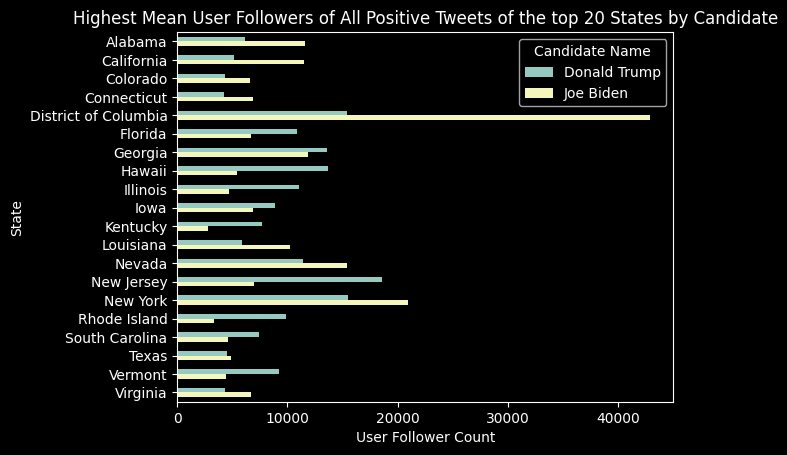

In [33]:
sns.barplot(data = pos_table_follower,x = 'user_followers_count', y = 'state', hue = 'Candidate Name', width = 0.5).set(title = 'Highest Mean User Followers of All Positive Tweets of the top 20 States by Candidate', xlabel = 'User Follower Count', ylabel = 'State')


#### Total Votes VS Average Likes by State
##### Notice how we observe a general positive corelation between average likes and total vote counts for most states.  Nevertheless, we can comfortably assert that there is a weak association between both the variables. There are some states which can be considered outliers and be removed. Moreover, if we look closely on the bottom left, there is a cluster which would indicate that both of them are indeed related to each other.

[Text(0.5, 1.0, 'Total Votes counted of all states with average likes of positive tweets'),
 Text(0.5, 0, 'Average Likes'),
 Text(0, 0.5, 'Total Votes'),
 (0.0, 10.0)]

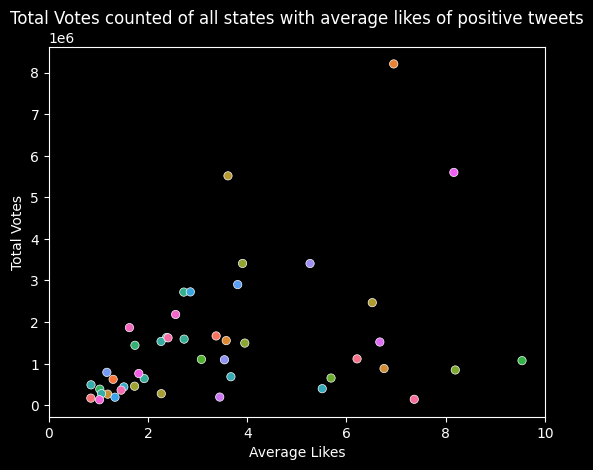

In [34]:
sns.scatterplot(data = mean_pos_table,x = 'likes', y = 'total_votes', hue = 'state', legend = False).set(title = 'Total Votes counted of all states with average likes of positive tweets',xlabel= 'Average Likes', ylabel = 'Total Votes', xlim=(0, 10))

#### Total Votes vs Average Retweet Count
##### In this scatter plot we can observe a general positive corelation between average retweet counts and total vote counts for most states. Moreover, there is a weak association between both the variables meaning that some states do not follow the general trend strictly. So, there can be some states which can be considered outliers and be removed. Moreover, if we look closely on the bottom half of the plot, there is a cluster which would indicate that both variables are corelated to each other.
 

[Text(0.5, 1.0, 'Total Votes counted of all states against average retweet counts of positive tweets'),
 Text(0.5, 0, 'Average Retweet Count'),
 Text(0, 0.5, 'Total Votes'),
 (0.0, 4.0)]

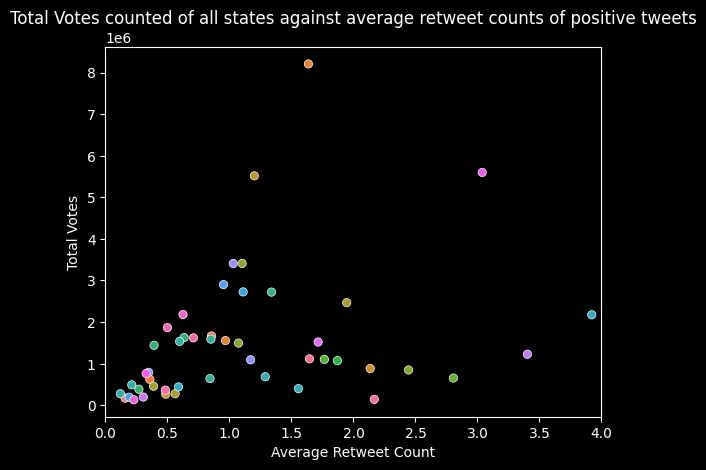

In [35]:
sns.scatterplot(data = mean_pos_table,x = 'retweet_count', y = 'total_votes', hue = 'state', legend = False).set(title = 'Total Votes counted of all states against average retweet counts of positive tweets', xlabel = 'Average Retweet Count', ylabel = 'Total Votes',xlim=(0, 4))

#### Total Votes vs Average User Follower
##### Through this plot, we can infer a direct corelation between average user follower count and total vote counts for most states. Moreover, there is a partially strong association between both the variables if we see the bottom half of the plot. However, some states do not follow the general trend and maybe considered outliers. 

[Text(0.5, 1.0, 'Total Votes counted of all states with average user follower count of only positive tweets'),
 Text(0.5, 0, 'Average User Follower'),
 Text(0, 0.5, 'Total Votes'),
 (0.0, 15000.0)]

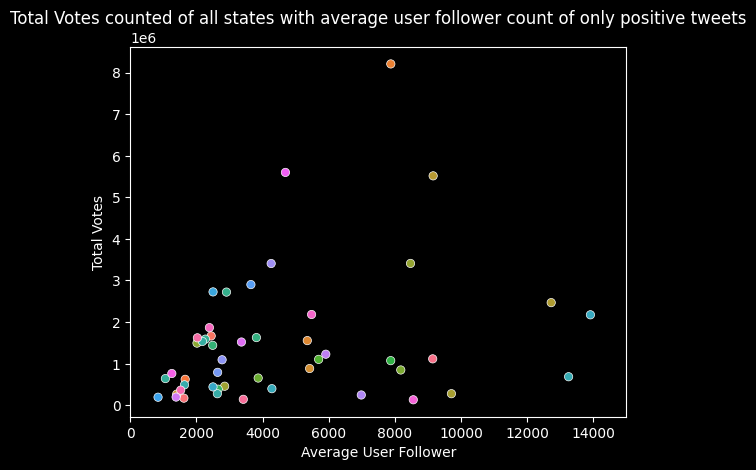

In [36]:
sns.scatterplot(data = mean_pos_table,x = 'user_followers_count', y = 'total_votes', hue = 'state', legend = False).set(title = 'Total Votes counted of all states with average user follower count of only positive tweets', xlabel = 'Average User Follower', ylabel = 'Total Votes', xlim=(0, 15000))

## Conclusion
##### The project essentially aimed to demonstrate the relationship between different variables that kept the public enagaged in social media platforms like Twitter and share their opinions in different ways. Some people like tweets while others can retweet it to show their support or interest towards an idea. This activity of liking and retweeting can significantly reflect people's emotions at a certain time or in a certain region. Sentiment Analysis helped identify which states were happy to support Biden or Trump pretty straighforwardly. The Statistics tables indicated on average how much people were interested in the campaign and how many likes and retweet counts was each candidate receiving. Moreover, the comparison of only positive tweets with regular tweets also illustrated the differences in public engagement on such tweets. We could have used the negative sentiment (we would expect the relationship between variables to be the opposite) tweets as well but it would have made the analysis unbalance. 

##### The plots were also a good way to visualize which candidate was provoking more public engagement in certain states. We used the top 20 states with highest averages to check which candidate was winning. Most of the States mentioned in the bar plots, Biden was the one with more engagement on twitter due to high number of likes and retweets. Thus, without a doubt Biden was the final winner. Similarly, the scatter plots demostrated that vote counts and average likes had some sort of weak relation. Moreover, there were clusters in both the average likes and avergae retweet count plots showing that both variables moved together.